# I. Declare dependencies

In [1]:
!pip install dtw
!pip install hmmlearn

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import glob
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display
import IPython.display

In [3]:
class Config:
    n_mfcc = 13
    hop_length = 220
    n_fft = 512
    n_frame = 12
    
c = Config()

# II. Extrac MFCC features

Use the collected data (in groups), extracting the  MFCC  feature (39 features, including  MFCC, delta, deltadelta) of each voice command / number.

#### 2.1 Set path, create dataframe

Create list contain all paths to my group member

In [4]:
my_group_member = ['./19021372_BuiVanToan', './19021381_NguyenVanTu', 
            './19021384_NguyenManhTuan', './19021396_PhamThanhVinh']

Create dataframe

In [5]:
# audio file data, hand-labeled with audacity software, 
# has a .wav audio file name with the same name as its label .txt file
df = pd.DataFrame(columns=["fid", "label", "start", "end"])

In [6]:
df

,fid,label,start,end


In [7]:
for mname in my_group_member:
    df_mi = pd.DataFrame(columns=["fid", "label", "start", "end"])
    data_dir = mname
    label_fnames = glob.glob(os.path.join(data_dir, "*.txt"))
    label_fnames = [os.path.basename(label_fname) for label_fname in label_fnames]

    for fname in label_fnames:
        df_i = pd.read_csv(os.path.join(data_dir, fname), sep="\t", header=None)
        df_i = df_i.rename(columns={2:"label", 0:"start", 1:"end"})
        df_i["fid"] = [mname + '\\' + fname.split('.')[0]]*len(df_i)
        df_mi = pd.concat([df_mi, df_i], axis=0, ignore_index=True)

    df = pd.concat([df, df_mi], axis=0, ignore_index=True)

In [8]:
df.head(3)

,fid,label,start,end
0,./19021372_BuiVanToan\1-10,sil,0.000000,2.426485
1,./19021372_BuiVanToan\1-10,7,2.426485,2.821224
2,./19021372_BuiVanToan\1-10,tram,3.181134,3.657143


In [9]:
df.tail(3)

,fid,label,start,end
7315,./19021396_PhamThanhVinh\c99,linh,4.461009,4.685341
7316,./19021396_PhamThanhVinh\c99,8,4.685341,4.989792
7317,./19021396_PhamThanhVinh\c99,sli,4.989792,5.400000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7318 entries, 0 to 7317
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fid     7318 non-null   object 
 1   label   7318 non-null   object 
 2   start   7318 non-null   float64
 3   end     7318 non-null   float64
dtypes: float64(2), object(2)
memory usage: 228.8+ KB


Check unique label in dataframe, there are 20

In [11]:
labels = list(df['label'].unique())
print(len(labels), len(labels)== 20 )
print(labels)

23 False
['sil', '7', 'tram', '6', 'muoi', '9', 'trieu', '8', '3', '2', 'nghin', 'linh', '4', '5', 'tu', 'mot', 'm1', 'lam', '1', '0', 'lnh', 'trsm', 'sli']


Correct the wrong label name

In [12]:
df['label'].replace('lnh', 'linh', inplace=True)
df['label'].replace('trsm', 'tram', inplace=True)
df['label'].replace('sli', 'sil', inplace=True)

In [13]:
labels = list(df['label'].unique())
print(len(labels), len(labels)== 20 )
print(labels)

20 True
['sil', '7', 'tram', '6', 'muoi', '9', 'trieu', '8', '3', '2', 'nghin', 'linh', '4', '5', 'tu', 'mot', 'm1', 'lam', '1', '0']


#### 2.2 Func to calculate mfcc for each 'word'/'sound'

In [14]:
def get_mfcc_features(x, sound, sr, hop_length):
    # start sample, end sample, and calculate mfcc in the interval (s, e)
    s, e = int(np.floor(x.loc["start"]*sr)), int(np.ceil(x.loc["end"]*sr))
    mfcc = librosa.feature.mfcc(y=sound[s:e], sr=sr, n_mfcc=c.n_mfcc, n_fft=c.n_fft, hop_length=hop_length)

    delta = librosa.feature.delta(mfcc, width=3)
    delta_2 = librosa.feature.delta(mfcc, order=2, width=3)
    features = np.concatenate((mfcc, delta, delta_2))
    
    # The 'features' calculated array is of the form (39, 74), whose mfcc features are vectors of length 39
    # we will transpose the matrix
    return features.T

#### 2.3 Calculate MFCC over dataframe

In [15]:
# Get unique file names (fids)
fids = df['fid'].unique()

In [16]:
for fid in fids:
    sound_file_path = os.path.join(fid+".wav")
    # optimize calculation speed by read files only once
    sound, sr = librosa.load(sound_file_path)
    dfi = df[df["fid"] == fid]
    
    # store mfcc in 
    # 'apply' function is used dataframe along data vertical axis
    df.loc[df["fid"] == fid, "mfcc_origin"] = dfi.apply(get_mfcc_features, args=(sound, sr, c.hop_length), axis=1)

In [17]:
df.head(3)

,fid,label,start,end,mfcc_origin
0,./19021372_BuiVanToan\1-10,sil,0.000000,2.426485,"[[-296.9526, 123.99669, -0.2854234, 9.288038, ..."
1,./19021372_BuiVanToan\1-10,7,2.426485,2.821224,"[[-378.6088, 114.13159, 6.1494083, 7.1754503, ..."
2,./19021372_BuiVanToan\1-10,tram,3.181134,3.657143,"[[-488.46213, 128.77538, -14.592409, 19.957142..."


#### 2.4 Draw some MFCCs corresponding to it's label

label:  sil
(frame, 3xband):  (244, 39)


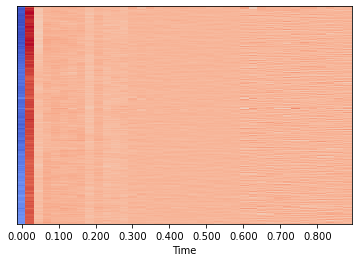

In [18]:
i_th = 0
print("label: ", df['label'].iloc[i_th])
m = df['mfcc_origin'].iloc[i_th]

print('(frame, 3xband): ', m.shape)

librosa.display.specshow(m, x_axis='time')
plt.show()

label:  nghin
(frame, 3xband):  (51, 39)


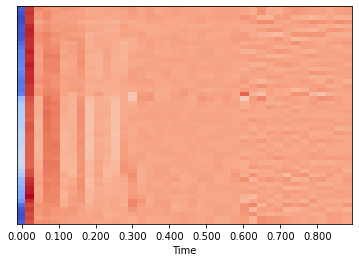

In [19]:
i_th = 12
print("label: ", df['label'].iloc[i_th])
m = df['mfcc_origin'].iloc[i_th]

print('(frame, 3xband): ', m.shape)

librosa.display.specshow(m, x_axis='time')
plt.show()